In [1]:
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torchvision.models as models
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define your dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = "InfraredSolarModules/" + self.dataframe.iloc[idx]['image_filepath']
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.0  # Normalize to [0, 1]
        label = int(self.dataframe.iloc[idx]['class_code'])
        if self.transform:
            img = self.transform(img)
        return img, label

In [3]:
# Read data
DataSolarModules = pd.read_json('InfraredSolarModules/module_metadata.json').transpose().sort_index()
Classes = DataSolarModules['anomaly_class'].unique()
class_to_number = dict(enumerate(Classes.flatten(), 0))
class_to_number = {v: k for k, v in class_to_number.items()}

In [4]:
def map_to_class(value):
    return class_to_number.get(value, 'Unknown')

DataSolarModules['class_code'] = DataSolarModules['anomaly_class'].apply(map_to_class)

In [5]:
# Split data indices
datos = list(range(0,len(DataSolarModules)))
np.random.shuffle(datos)
data_train_idx, data_test_idx = train_test_split(datos, test_size=0.2)
data_train_idx, data_val_idx = train_test_split(data_train_idx, test_size=0.25)

In [6]:
# Get corresponding data using indices
data_train = DataSolarModules.iloc[data_train_idx]
data_val = DataSolarModules.iloc[data_val_idx]
data_test = DataSolarModules.iloc[data_test_idx]

In [7]:
# Prepare datasets and data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))  # Resize images to match input size expected by DenseNet
])

In [8]:
train_dataset = CustomDataset(data_train, transform=transform)
val_dataset = CustomDataset(data_val, transform=transform)
test_dataset = CustomDataset(data_test, transform=transform)

In [9]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [10]:
# Initialize DenseNet model
class DenseNetGray(nn.Module):
    def __init__(self):
        super(DenseNetGray, self).__init__()
        self.densenet = models.densenet121(pretrained=False)
        # Modify first convolution layer to accept single-channel input
        self.densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=7, padding=3, bias=False)
        
    def forward(self, x):
        return self.densenet(x)

In [11]:
# Initialize model
model = DenseNetGray()

/home/ecappiell/Development/Deep Learning/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ecappiell/Development/Deep Learning/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [12]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

In [13]:
# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

In [14]:
# Training loop
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DenseNetGray(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(7, 7), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, moment

In [15]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    
    # Validation loop
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item() * images.size(0)
        epoch_val_loss = val_running_loss / len(val_dataset)
        val_losses.append(epoch_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

Epoch [1/20], Training Loss: 1.4209, Validation Loss: 1.7404
Epoch [2/20], Training Loss: 1.0681, Validation Loss: 1.4443
Epoch [3/20], Training Loss: 0.9458, Validation Loss: 1.2770
Epoch [4/20], Training Loss: 0.8358, Validation Loss: 0.9829
Epoch [5/20], Training Loss: 0.7575, Validation Loss: 1.5813
Epoch [6/20], Training Loss: 0.6932, Validation Loss: 0.8708
Epoch [7/20], Training Loss: 0.6148, Validation Loss: 0.8465
Epoch [8/20], Training Loss: 0.5631, Validation Loss: 0.7148
Epoch [9/20], Training Loss: 0.5000, Validation Loss: 0.7328
Epoch [10/20], Training Loss: 0.4263, Validation Loss: 0.9763
Epoch [11/20], Training Loss: 0.3881, Validation Loss: 0.7528
Epoch [12/20], Training Loss: 0.3156, Validation Loss: 0.8485
Epoch [13/20], Training Loss: 0.2706, Validation Loss: 0.8760
Epoch [14/20], Training Loss: 0.2369, Validation Loss: 1.0144
Epoch [15/20], Training Loss: 0.1865, Validation Loss: 1.0161
Epoch [16/20], Training Loss: 0.1424, Validation Loss: 1.0436
Epoch [17/20], Tr

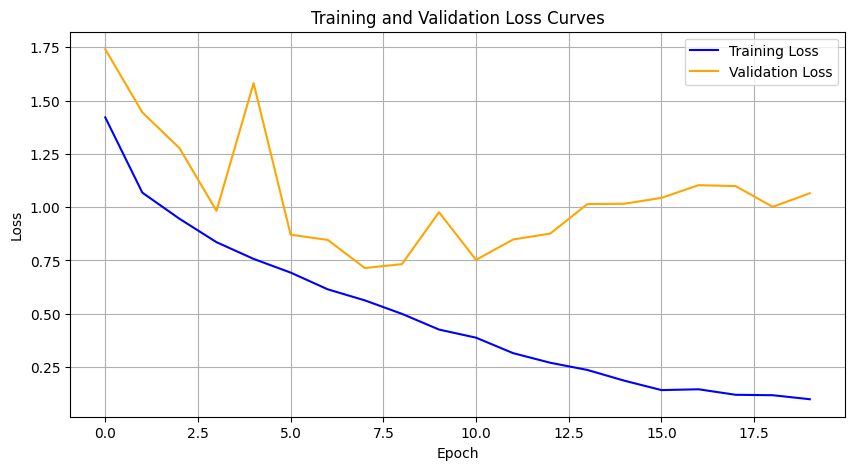

In [16]:
# Plotting training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {(correct/total)*100:.2f}%")

Accuracy on test set: 78.57%


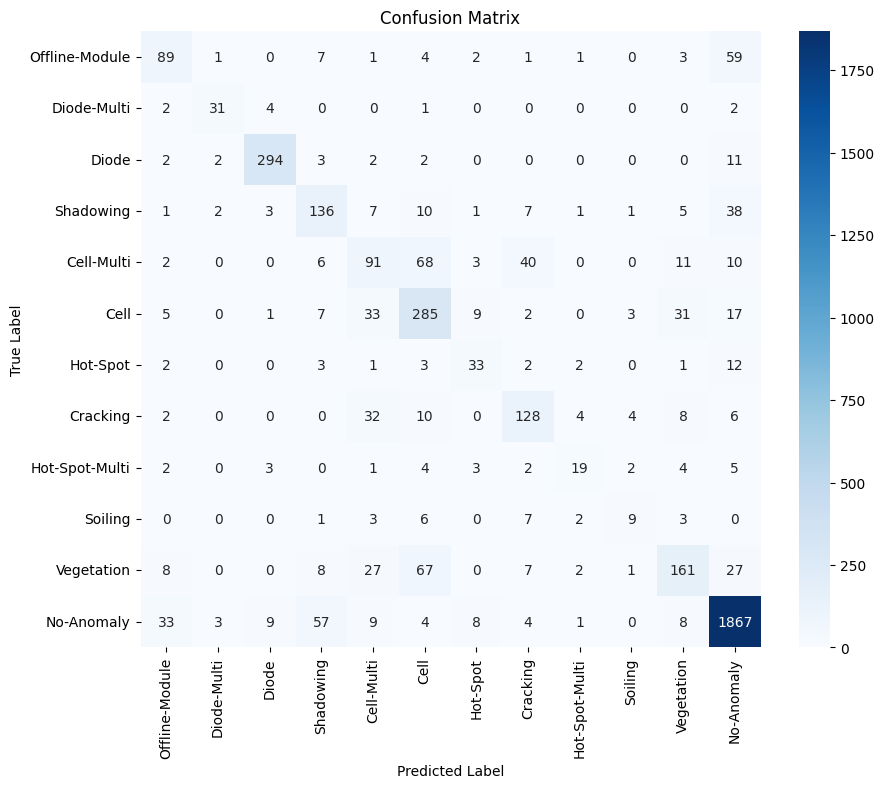

In [18]:
# Initialize lists to store predictions and ground truth labels
predicted_labels = []
true_labels = []

# Evaluate model on test set and gather predictions
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=Classes, yticklabels=Classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
